# CNN for Hate Speech Classification

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LeakyReLU
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import gensim
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import shap

from text_preprocess import clean_text
from results import plot_results

In [3]:
# Load datasets
train_df = pd.read_csv("C:\\Users\\aysen\\Documents\\GitHub\\hate_speech_models\\data\\annotations_metadata_train.csv")
test_df = pd.read_csv("C:\\Users\\aysen\\Documents\\GitHub\\hate_speech_models\\data\\annotations_metadata_test.csv")

# Text cleaning
X_train = train_df['text'].apply(clean_text)
X_test = test_df['text'].apply(clean_text)

# Tokenization and padding
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
max_len = max(len(seq) for seq in X_train_sequences) # Sequence with max length = 326
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len)

# Binary label encoding
y_train = (train_df['label'] == 'hate').astype(int)
y_test = (test_df['label'] == 'hate').astype(int)

y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)


In [4]:
# Load Word2Vec model
word2vec_path = "C:\\Users\\aysen\\Documents\\GitHub\\hate_speech_models\\GoogleNews-vectors\\GoogleNews-vectors-negative300.bin"
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [5]:
# Create embedding matrix
embedding_dim = word2vec_model.vector_size # embedding_dim = 300
word_index = tokenizer.word_index
num_words = len(word_index) + 1            # num_words = 5787
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]

print (f"embedding_dim: {embedding_dim}")
print (f"num_words: {num_words}")

embedding_dim: 300
num_words: 5787


In [6]:
# Hyperparameters
epochs = 20
batch_size = 32
num_filters = 256
learning_rate = 0.0001
patience = 10
l2_constraint = 0.01

In [7]:
# CNN model
cnn_model = Sequential([

    # Embedding layer
    # Input shape: 2D tensor with shape: (batch_size, input_length)
    # Output shape: 3D tensor with shape: (batch_size, input_length, output_dim)
    Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True),

    Conv1D(filters=num_filters, kernel_size=3, activation=LeakyReLU(alpha=0.1), kernel_regularizer=l2(l2_constraint)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=num_filters, kernel_size=4, activation=LeakyReLU(alpha=0.1), kernel_regularizer=l2(l2_constraint)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=num_filters, kernel_size=5, activation=LeakyReLU(alpha=0.1), kernel_regularizer=l2(l2_constraint)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation=LeakyReLU(alpha=0.1)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])



In [8]:
# Early stopping
callback = EarlyStopping(monitor='val_loss', patience=patience)

# Train the model
cnn_model_history = cnn_model.fit(X_train_padded, y_train_tensor, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[callback])

Epoch 1/20


48/48 [==============================] - 6s 100ms/step - loss: 7.6306 - accuracy: 0.5356 - val_loss: 6.7104 - val_accuracy: 0.6136
Epoch 2/20
48/48 [==============================] - 4s 88ms/step - loss: 5.9702 - accuracy: 0.6127 - val_loss: 5.2495 - val_accuracy: 0.6475
Epoch 3/20
48/48 [==============================] - 4s 89ms/step - loss: 4.6797 - accuracy: 0.6336 - val_loss: 4.1183 - val_accuracy: 0.6527
Epoch 4/20
48/48 [==============================] - 4s 90ms/step - loss: 3.6841 - accuracy: 0.6381 - val_loss: 3.2476 - val_accuracy: 0.6554
Epoch 5/20
48/48 [==============================] - 5s 96ms/step - loss: 2.9212 - accuracy: 0.6421 - val_loss: 2.5872 - val_accuracy: 0.6632
Epoch 6/20
48/48 [==============================] - 4s 90ms/step - loss: 2.3248 - accuracy: 0.6937 - val_loss: 2.0732 - val_accuracy: 0.6893
Epoch 7/20
48/48 [==============================] - 4s 88ms/step - loss: 1.8660 - accuracy: 0.7289 - val_loss: 1.7147 - val_accuracy: 0.7050
Epoch 8/20

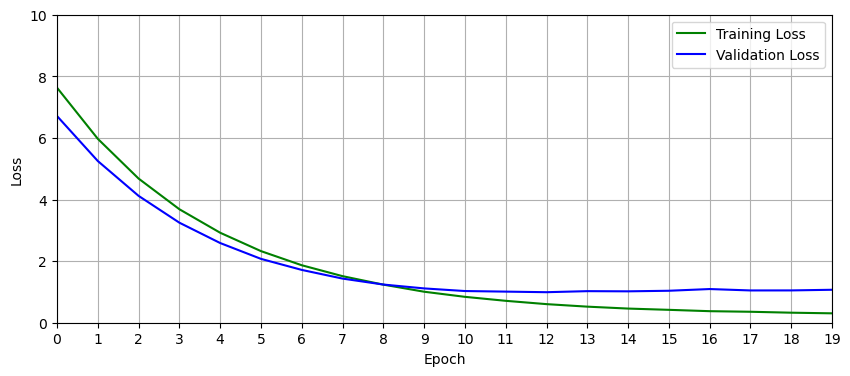

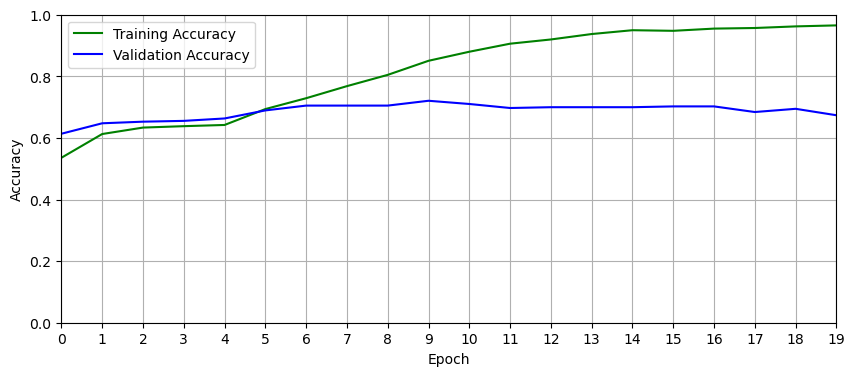

In [9]:
# Retrieve training results
train_loss = cnn_model_history.history["loss"]
train_acc  = cnn_model_history.history["accuracy"]
valid_loss = cnn_model_history.history["val_loss"]
valid_acc  = cnn_model_history.history["val_accuracy"]
   
plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 10.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"], epochs=epochs);
 
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"], epochs=epochs)

In [10]:
# Tokenization and padding
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_test)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)


test_loss, test_acc = cnn_model.evaluate(X_test_padded, y_test_tensor)
print(f"Test accuracy: {test_acc*100:.3f}")

y_pred = cnn_model.predict(X_test_padded)

# Convert predictions to binary values (0 or 1) based on a threshold
threshold = 0.5
y_pred_binary = [1 if pred > threshold else 0 for pred in y_pred]

# Evaluate the performance using metrics like accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

print('\n')
print(classification_report(y_test, y_pred_binary, target_names=['noHate', 'hate']))

15/15 [==============================] - 0s 22ms/step - loss: 1.6833 - accuracy: 0.5774
Test accuracy: 57.741
15/15 [==============================] - 1s 21ms/step
F1 Score: 0.5860655737704918
Precision: 0.5742971887550201
Recall: 0.5983263598326359


              precision    recall  f1-score   support

      noHate       0.58      0.56      0.57       239
        hate       0.57      0.60      0.59       239

    accuracy                           0.58       478
   macro avg       0.58      0.58      0.58       478
weighted avg       0.58      0.58      0.58       478



In [11]:
# Load SHAP explainer
explainer = shap.Explainer(cnn_model, X_train_padded)

# Compute SHAP values for test data
#shap_values = explainer.shap_values(X_test_padded)

# Visualize SHAP values
#shap.summary_plot(shap_values, X_test_padded, feature_names=list(word_index.keys()), class_names=['noHate', 'hate'])

print (X_test_padded.shape)
print (X_test_padded[1])
print (X_test_padded[1:2])

(478, 326)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0

In [12]:
shap_val = explainer.shap_values(X_test_padded)

PermutationExplainer explainer: 479it [15:34:25, 117.29s/it]                           


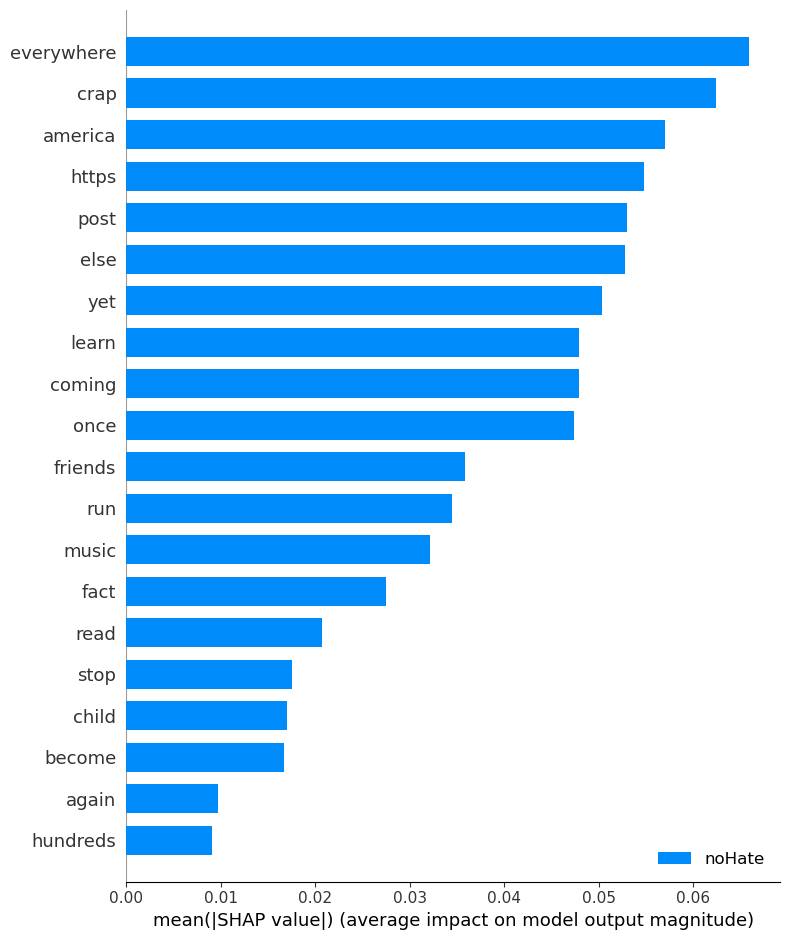

In [16]:
shap_values = []
shap_values.append(shap_val)

shap.summary_plot(shap_values, X_test_padded, feature_names=list(word_index.keys()), class_names=['noHate', 'hate'])